# Self-Driving Car Engineer Nanodegree

## Project: Finding Lane Lines on the Road

In this project, I'm going to find lane lines on the road. The lane lines could be white or yellow in color. In the following code cells, I have placed code step by step manner along with the respective explaination. So, let's start with importing all the required packages.

## Imports

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

import math
import os


## Helper Functions

Following are the provided helper functions along with some custom functions which I created for use in the pipeline.

In [2]:

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def auto_threshold_canny(original_image, src_image):
    """ Compute the median of the single channel pixel intensities and
        use it to determine low and high thresholds for canny edge detection function.
    Source: https://www.pyimagesearch.com/2015/04/06/zero-parameter-automatic-canny-edge-detection-with-python-and-opencv/
    """
    m = np.median(original_image)
    sigma=0.33
    # apply automatic Canny edge detection using the computed median
    low_threshold = int(max(0, (1.0 - sigma) * m))
    high_threshold = int(min(255, (1.0 + sigma) * m))
    return canny(src_image, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = [255] * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1, γ=0):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

Following code lists all the test images which can be used to detect lane lines in them.

In [3]:
files = os.listdir("test_images/")
files.sort()
for file in files:
    print(file)

lane_test1.JPG
lane_test2.jpg
lane_test3.jpg
lane_test4.jpg
lane_test5.jpg
lane_test6.jpg
lane_test7.jpg
solidWhiteCurve.jpg
solidWhiteRight.jpg
solidYellowCurve.jpg
solidYellowCurve2.jpg
solidYellowLeft.jpg
whiteCarLaneSwitch.jpg


# Read the image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


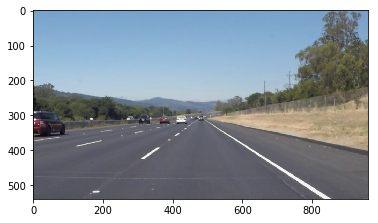

In [112]:
#reading in an image
im_name = 'solidWhiteRight.jpg'
image = mpimg.imread('test_images/' + im_name)
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)

## Decide color thresholds

Following cell contains code to maks out the regions which do not meet the color specifications. Areas of the image which do not contain sufficient intensities of read, green and blue color have to be made black. The color intensity of a particular color is decided by taking appropriate fractions multiplied by the median of that color component in full image, so as to compensate for the overall lighting condition.

In [113]:
#### highlight lanes in selected region ####
regular_median_color = 80    # median color for a image with excellent visibility conditions
d_factor = 15                # factor to decide the effect of overall median color on the thresholds
red_threshold = 220 - (regular_median_color - np.median(image[:,:, 0]))/d_factor
green_threshold = 220 - (regular_median_color - np.median(image[:,:, 1]))/d_factor
blue_threshold = 220 - (regular_median_color - np.median(image[:,:, 2]))/d_factor

color_thresholds = (image[:,:, 0] > red_threshold)\
                | (image[:,:, 1] > green_threshold)\
                | (image[:,:, 2] > blue_threshold)

## Decide region thresholds

Created a triangular region having height equal to half of the original image. Created a mask to remove the unwanted region.

In [114]:
#### create a mask for selected region ####
# Pull out the x and y sizes
ysize = image.shape[0]
xsize = image.shape[1]

# Define a triangle region of interest
left_bottom = [50, ysize-20]
right_bottom = [xsize-50, ysize-20]
apex = [xsize//2, ysize//2]

# Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
# np.polyfit returns the coefficients [A, B] of the fit
fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

# Find the region inside the lines
XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                    (YY > (XX*fit_right[0] + fit_right[1])) & \
                    (YY < (XX*fit_bottom[0] + fit_bottom[1]))

## Mask out unwanted colors in selected region

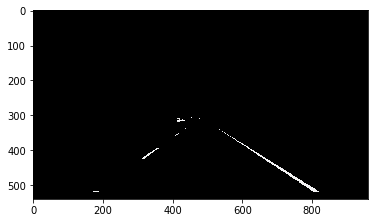

In [115]:
lane_select = np.copy(image)
lane_select[~color_thresholds | ~region_thresholds] = [0, 0, 0]
plt.imshow(lane_select)
#mpimg.imsave("test_images_output/roi/"+ im_name, lane_select)

## Detect edges in this image

Now, edges in above image would be detected by using Canny edge detection algorithm. The image is blurred using gaussain blur algorithm before edged detection. Low and high thresholds for canny algorithm are calculated by taking median of single channel pixel intensities and using the computed median for low and high thresholds.

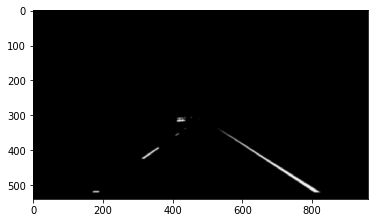

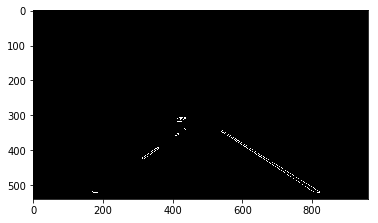

In [116]:
#### soften this image ####
kernel_size = 9
blur_image = gaussian_blur(lane_select, kernel_size)
plt.imshow(blur_image)
plt.show()
#mpimg.imsave("test_images_output/soften/" + im_name, blur_image)

edges = auto_threshold_canny(image, blur_image)
plt.imshow(edges, cmap="gray")
plt.show()
#mpimg.imsave("test_images_output/edges/" + im_name, edges, cmap="gray")

## Apply Hough Transform and annotate lane lines

To identified lane lines, Hough transform is applied on canny edge detected image. The lines obtained are seperated based on positive and negative slope to identify right and left lanes respectively. Then actual slope and intercept are identified by taking their weighted average by line length. Lane lines are then drawn from bottom of the image till one third height of original image from bottom.

In [117]:
#### apply hough transform on edge image to get highlighted lane lines for selected region ####
rho = 1  # distance resolution in pixels of the hough grid
theta = np.pi/180  # angular resolution in hough grid
threshold = 10     # minimum number of votes (intersections in hough grid)
min_line_len = 10  # minimum number of pixels making up a line
max_line_gap = 300    # maximum gap in pixels between connectable line segments
line_image = np.copy(image)   
line_only_image = np.copy(image)*0   # creating a blank to draw lines on
# Output "lines" containing endpoints of detected line segments
lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)

#### mask out all the colors from the hough transformed image except lane lines ####
draw_lines(line_image, lines)
# find positive and negative slope lines and get average positive and negative slopes respectively
pm = []    # list of positive slopes
pc = []    # list of intercepts of lines with positive slopes
pl = []    # list of lengths of lines with positive slopes
nm = []    # list of negative slopes
nc = []    # list of intercepts of lines with negative slopes
nl = []    # list of lengths of lines with negative slopes

# get line details in lists
for line in lines:
    for x1, y1, x2, y2 in line:
        m = (y2-y1)/(x2-x1)
        c = y1 - m*x1
        l = math.sqrt(((y2-y1)**2) + ((x2-x1)**2))
        if m < 0:
            nm.append(m)
            nc.append(c)
            nl.append(l)
        elif m > 0:
            pm.append(m)
            pc.append(c)
            pl.append(l)

# get the average of slopes and intercepts weighted by lengths
a_pm = np.average(pm, weights=pl)
a_nm = np.average(nm, weights=nl)

a_pc = np.average(pc, weights=pl)
a_nc = np.average(nc, weights=nl)

# create two extrapolated lines
lines = []
for dt in [a_pm, a_pc],[a_nm, a_nc]:
    m = dt[0]
    c = dt[1]
    y1 = ysize
    x1 = int((y1 - c)/m)
    y2 = y1-(ysize//3)-30
    x2 = int((y2 - c)/m)
    line = [[x1, y1, x2, y2]]
    lines.append(line)

draw_lines(line_only_image, lines, thickness=15)

# Overlay lines on original image

Image with all the detected lines.


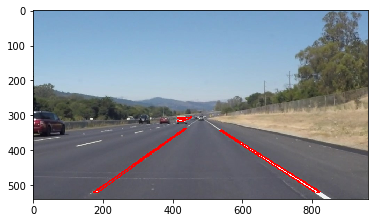

Image with extrapolated and averaged lines


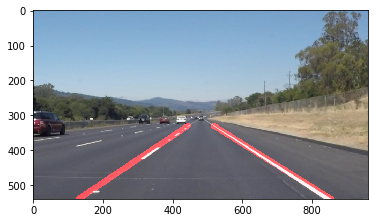

In [118]:
#kernel_size = 1
#line_image = gaussian_blur(line_image, kernel_size)
print("Image with all the detected lines.")
plt.imshow(line_image)
plt.show()
#mpimg.imsave("test_images_output/hough_lines/" + im_name, line_image)
#### mask this image on original image within selected region ####
result = weighted_img(image, line_only_image)
print("Image with extrapolated and averaged lines")
plt.imshow(result)
plt.show()
#mpimg.imsave("test_images_output/output/" + im_name, result)

# Test on Videos

Following are the test videos where this pipeline has to be tested.

In [66]:
files = os.listdir("test_videos/")
files.sort()
for file in files:
    print(file)

challenge.mp4
solidWhiteRight.mp4
solidYellowLeft.mp4


## Imports for Video Processing

In [67]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

## Function to Process an Image frame in Video

This function contains the consolidated image processing code to find and annotate lane lines on the road in the video. Memory of four previous frames' lane line data is also used to avoid any flickering and facilitate smooth detection of lane lines even if a bad frame is encountered.

In [71]:
pre_data = [[], [], [], []]

def process_image(image):
    global pre_data
    #### highlight lanes in selected region ####
    regular_median_color = 80    # median color for a image with excellent visibility conditions
    d_factor = 25                # factor to decide the effect of overall median color on the thresholds
    red_threshold = 220 - (regular_median_color - np.median(image[:,:, 0]))/d_factor
    green_threshold = 220 - (regular_median_color - np.median(image[:,:, 1]))/d_factor
    blue_threshold = 220 - (regular_median_color - np.median(image[:,:, 2]))/d_factor

    color_thresholds = (image[:,:, 0] > red_threshold)\
                    | (image[:,:, 1] > green_threshold)\
                    | (image[:,:, 2] > blue_threshold)
    
    #### create a mask for selected region ####
    # Pull out the x and y sizes
    ysize = image.shape[0]
    xsize = image.shape[1]

    # Define a triangle region of interest
    left_bottom = [50, ysize-20]
    right_bottom = [xsize-50, ysize-20]
    apex = [xsize//2, ysize//2]

    # Perform a linear fit (y=Ax+B) to each of the three sides of the triangle
    # np.polyfit returns the coefficients [A, B] of the fit
    fit_left = np.polyfit((left_bottom[0], apex[0]), (left_bottom[1], apex[1]), 1)
    fit_right = np.polyfit((right_bottom[0], apex[0]), (right_bottom[1], apex[1]), 1)
    fit_bottom = np.polyfit((left_bottom[0], right_bottom[0]), (left_bottom[1], right_bottom[1]), 1)

    # Find the region inside the lines
    XX, YY = np.meshgrid(np.arange(0, xsize), np.arange(0, ysize))
    region_thresholds = (YY > (XX*fit_left[0] + fit_left[1])) & \
                        (YY > (XX*fit_right[0] + fit_right[1])) & \
                        (YY < (XX*fit_bottom[0] + fit_bottom[1]))
    
    lane_select = np.copy(image)
    lane_select[~color_thresholds | ~region_thresholds] = [0, 0, 0]
    
    #### soften this image ####
    kernel_size = 11
    blur_image = gaussian_blur(lane_select, kernel_size)
    edges = auto_threshold_canny(image, blur_image)
    
    #### apply hough transform on edge image to get highlighted lane lines for selected region ####
    rho = 1  # distance resolution in pixels of the hough grid
    theta = np.pi/180  # angular resolution in hough grid
    threshold = 20     # minimum number of votes (intersections in hough grid)
    min_line_len = 10  # minimum number of pixels making up a line
    max_line_gap = 250    # maximum gap in pixels between connectable line segments
    line_image = np.copy(image)   
    line_only_image = np.copy(image)*0   # creating a blank to draw lines on
    # Output "lines" containing endpoints of detected line segments
    lines = cv2.HoughLinesP(edges, rho, theta, threshold, np.array([]), min_line_len, max_line_gap)

    #### mask out all the colors from the hough transformed image except lane lines ####
    # uncomment below line to see raw lines draw on orignal video
    #return draw_lines(line_image, lines)
    # find positive and negative slope lines and get average positive and negative slopes respectively
    pm = []    # list of positive slopes
    pc = []    # list of intercepts of lines with positive slopes
    pl = []    # list of lengths of lines with positive slopes
    nm = []    # list of negative slopes
    nc = []    # list of intercepts of lines with negative slopes
    nl = []    # list of lengths of lines with negative slopes

    # get line details in lists
    for line in lines:
        for x1, y1, x2, y2 in line:
            m = (y2-y1)/(x2-x1)
            c = y1 - m*x1
            l = math.sqrt(((y2-y1)**2) + ((x2-x1)**2))
            if m < 0:
                nm.append(m)
                nc.append(c)
                nl.append(l)
            elif m > 0:
                pm.append(m)
                pc.append(c)
                pl.append(l)

    # get the average of slopes and intercepts weighted by lengths
    if sum(pl) != 0:
        a_pm = np.average(pm, weights=pl)
        a_pc = np.average(pc, weights=pl)
    else:
        a_pm = np.average(pm)
        a_pc = np.average(pc)
    
    if sum(nl) != 0:
        a_nm = np.average(nm, weights=nl)
        a_nc = np.average(nc, weights=nl)
    else:
        a_nm = np.average(nm)
        a_nc = np.average(nc)
    # create two extrapolated lines
    lines = []
    #check if current data is valid
    data_valid_flag = True
    if math.isnan(a_pm) | math.isnan(a_pc) | math.isnan(a_nm) | math.isnan(a_nc):
        data_valid_flag = False
    
    if data_valid_flag:
        if len(pre_data[0]) > 5:
            pre_data[0].pop(0)
            pre_data[1].pop(0)
            pre_data[2].pop(0)
            pre_data[3].pop(0)

        pre_data[0].append(a_pm)
        pre_data[1].append(a_pc)
        pre_data[2].append(a_nm)
        pre_data[3].append(a_nc)
    #calculate weights for previous frames
    wt = []
    for v in range(1, len(pre_data[0])+1):
        wt.append(v)
    #wt[-1] = wt[-1]*2
    # prepare data
    line_data = [[np.average(pre_data[0], weights=wt), np.average(pre_data[1], weights=wt)],\
                 [np.average(pre_data[2], weights=wt), np.average(pre_data[3], weights=wt)]]
     
    for i in range(2):
        m = line_data[i][0]
        c = line_data[i][1]
        y1 = ysize
        x1 = int((y1 - c)/m)
        y2 = y1-(ysize//3)-30
        x2 = int((y2 - c)/m)
        line = [[x1, y1, x2, y2]]
        lines.append(line)
    
    # draw lines on original image
    draw_lines(line_only_image, lines, thickness=15)
    result = weighted_img(image, line_only_image)
    return result

Now, let us test this function on solid white lanes video.

In [72]:
pre_data = [[], [], [], []]
white_output = 'test_videos_output/solidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████▌| 221/222 [00:30<00:00,  8.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

Wall time: 32.8 s


Play the output video.

In [73]:
HTML("""
<video style='width:960px;height:540px' controls>
  <source src="{0}">
</video>
""".format(white_output))

Testing on Yellow lanes.

In [25]:
pre_data = [[], [], [], []]
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████▊| 681/682 [01:13<00:00,  9.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

Wall time: 1min 15s


In [26]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

Testing with Challenge Video.

In [27]:
pre_data = [[], [], [], []]
challenge_output = 'test_videos_output/challenge.mp4'
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|█████████████████████████████████████████████████████████████████████████████████████████████| 251/251 [00:49<00:00,  5.01it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

Wall time: 52.5 s


In [28]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))